# Kapitza pendulum analysis by Otto Howe

## Objectives:
* Solve the dimensionless equation of motion for a Kapitza pendulum
* Design a method to test the motion for stability
* Create a contour plot of stability for differing values of epsilon and alpha
* Attempt to formulate an equation for the stability boundaries

## Approach
1. Import needed modules
2. Define the equation of motion for the Kapitza Pendulum
3. Define useful utilities
4. Define a function to solve the differential equation for given values
* This function will need a built-in stability analysis function as well
5. Plot contour maps to get a general idea of the stability "valley"
6. Attempt to formulate a set of equations that govern the stability of the Kapitza pendulum


## Step 1: Import needed modules
`time`: Useful for telling how long a code box needs to run\
`numpy`: Useful for math\
`solve_ivp`: To solve our differential equation numerically\
`matplot.lib`: To make cool graphs n stuff

In [ ]:
# import modules
import time
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Step 2: Define our equation of motion for pivot-driven pendulum

The equation of motion is:
$$ \theta'' + 2 \zeta \theta' + \left(\epsilon^2 - \alpha cos\tau \right)sin\theta = 0$$

Putting this in the form needed by the solver `solve_ivp`gives,

$$ \theta'' = - 2 \zeta \theta' - \left(\epsilon^2 - \alpha cos\tau \right)sin\theta$$

Note that $f' = \frac{df}{d\tau}$ with $\tau=\omega_d t$, a dimensionless time.

In [ ]:
# define equation of motion

def pivot_driven_pendulum(tau, y, epsilon, alpha, zeta):
  """
  This function defines the equation of motion for a pivot-driven pendulum.
  PARAMETERS:
  tau : float, ndarray
    dimesnionless time : tau = omega_d*t
  y : ndarray
    state variables [theta, ang_vel]
  alpha : float
    relative displacement of the pivot to the pendulum arm : alpha = y_0/l
  epsilon : float
    dimensionless frequency : epsilon = omega_0/omega_d
  zeta : float, optional
    dimensionless damping coefficient
  RETURNS:
  dy_dtau : ndarray
    time derivatives of state variables
  """
  theta, ang_vel = y # unpack state variable
  dtheta_dtau = ang_vel # define the angular velocity
  d2theta_dtau2 = -2*zeta*dtheta_dtau - (epsilon**2 - alpha*np.cos(tau))*np.sin(theta) # equation of motion
  dy_dtau = np.array([dtheta_dtau, d2theta_dtau2]) # pack variables
  return dy_dtau # return derivative

## Step 3: Define utilities

1. **`basic_plot`:** makes a basic plot duh

In [ ]:
# basic_plot
def basic_plot(t, y, xlabel=None, ylabel=None, figsize=(3,3)):
  """
  This function plots a time series of data.
  PARAMETERS:
  t : float, ndarray
    time
  y : float, ndarray
    data
  xlabel : str, optional
    x-axis label (default is None)
  ylabel : str, optional
    y-axis label (default is None)
  figsize : tuple, optional
    figure size (default is (3,3))
  """
  plt.figure(figsize=figsize)
  plt.plot(t, y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

## Step 4: Solve the equation of motion + find stability

### IVP solving function:
`average_long_timescale_response(epsilon, alpha, zeta, n_decay=100, delta_theta=0.01)`:
\
uses `solve_ivp` Radau method to find the solution for the IVP given the initial values. It has a built-in "stability function" shown below to describe how stable each solution is

### Stability function:
`tau_average_range` = np.linspace((n_decay-1)/(2*zeta), n_decay/(2*zeta), 1000) \
`cos_theta_averaging` = np.mean(np.cos(solution.sol(tau_average_range)[0]))
\
\
This stability function consists of just two lines and was shown in class. It works by averaging the value of cos(theta) in the solution over the number of decay times. Since we expect the Kapitza pendulum to be stable around theta = pi, our average value for cos(theta) should be very close to -1 as a long-time behavior for a stable instance. For now we will use `n_decay = 500` for long-time behavior.


In [ ]:
# input parameters
epsilon = 0.2
alpha = 0.3
zeta = 0.1

# number of decay times we want to integrate over
n_decay = 500
delta_theta = 0.01 # deviation of theta from pi/inverted state

# define span of tau
tau_min = 0
tau_max = n_decay/(2*zeta)
tau_span = [tau_min, tau_max]

def average_long_timescale_response(epsilon, alpha, zeta, n_decay=100, delta_theta=0.01):
  """
  This function calcs the longscale time response of a pivot-driven pendulum
  """

  # define an initial state
  theta_0 = np.pi - delta_theta
  ang_vel_0 = 0
  y_0 = [theta_0, ang_vel_0]

  # solve equation of motion
  solution = solve_ivp(pivot_driven_pendulum,
                      tau_span, y_0,
                      args=(epsilon, alpha, zeta),
                      method='Radau',
                      dense_output=True)

  #calculate our measure of the long scale time response
  tau_average_range = np.linspace((n_decay-1)/(2*zeta), n_decay/(2*zeta), 1000)
  cos_theta_averaging = np.mean(np.cos(solution.sol(tau_average_range)[0]))

  return cos_theta_averaging, solution

## Step 5: Plot contour maps

###Let's start with a low resolution map from 0 to 1. Values close to -1 are stable. To save time, we will consider an average over 50 decay times as 'long-time' behavior analysis. This should still be plenty.

###Psuedocode for integrating the system given the values for (epsilon, alpha):

- For the first value of epsilon:
Solve the IVP for every value of alpha and store in a list
- Repeat for the next value of epsilon
- Repeat until all values of epsilon are covered


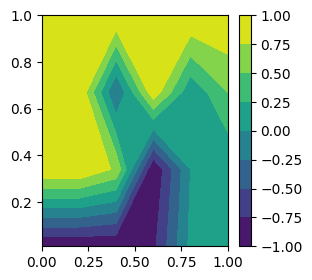

In [54]:
# input parameters
epsilon_list = np.linspace(0.01, 1, 4)
alpha_list = np.linspace(0,1,6)
zeta = 0.1

#initialize our mesh for the average long time scale response
cos_theta_mesh = np.zeros((len(epsilon_list), len(alpha_list)))

# number of decay times we want to integrate over
n_decay = 50

#solving the IVP's for every value of epsilon and alpha on the specified range
for i, epsilon in enumerate(epsilon_list):
  for j, alpha in enumerate(alpha_list):
    cos_theta_averaging, solution, = average_long_timescale_response(epsilon, alpha, zeta, n_decay=n_decay)
    cos_theta_mesh[i,j] = cos_theta_averaging

#plotting the contour map
plt.figure(figsize=(3,3))
plt.contourf(alpha_list, epsilon_list, cos_theta_mesh) # Changed to contourf for filled contours
plt.colorbar()
plt.show()

### Seeing the general area at a value of -1, we can now plot a higher resolution map of the stability valley. The higher resolution map is coded below, it takes Google Colab about 30 minutes to compute


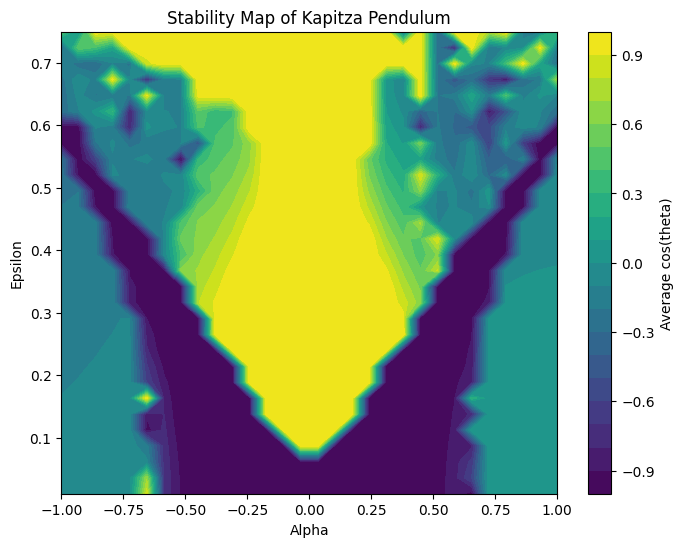

In [ ]:
# input parameters
epsilon_list = np.linspace(0.01, 0.75, 30)
alpha_list = np.linspace(-1,1,30)
zeta = 0.1

#initialize our mesh for the average long time scale response
cos_theta_mesh = np.zeros((len(epsilon_list), len(alpha_list)))

# number of decay times we want to integrate over
n_decay = 50

for i, epsilon in enumerate(epsilon_list):
  for j, alpha in enumerate(alpha_list):
    cos_theta_averaging, solution, = average_long_timescale_response(epsilon, alpha, zeta, n_decay=n_decay)
    cos_theta_mesh[i,j] = cos_theta_averaging


plt.figure(figsize=(8,6)) # Increased figure size for better visualization
plt.contourf(alpha_list, epsilon_list, cos_theta_mesh, levels=20) # Added levels for smoother contours
plt.colorbar(label='Average cos(theta)')
plt.xlabel('Alpha')
plt.ylabel('Epsilon')
plt.title('Stability Map of Kapitza Pendulum')
plt.show()



### Comments:

###I would only consider the very dark purple area, values below -0.9 at the very most, to even be considered as possibly stable. It's interesting to note the symmetry between the positive and negative values for alpha.
\
###Our goal here is to find a boundary function for this stability valley. In the assignment, it is clearly specified that it should be alpha as a function of epsilon so we need to swap the axes on this graph


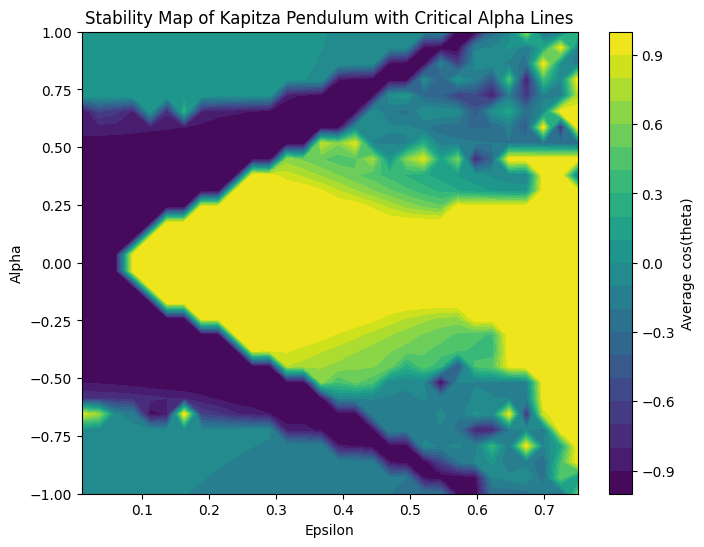

In [ ]:
#Swapping axes and transposing the theta mesh
plt.figure(figsize=(8,6)) # Increased figure size for better visualization
plt.contourf(epsilon_list, alpha_list, cos_theta_mesh.T, levels=20) # Added levels for smoother contours, and transposed cos_theta_mesh
plt.colorbar(label='Average cos(theta)')
plt.xlabel('Epsilon')
plt.ylabel('Alpha')
plt.title('Stability Map of Kapitza Pendulum with Critical Alpha Lines')
plt.show()

###It would appear that our function of alpha(epsilon) would not be a function at all on this range since it doesn't pass the vertical line test. However, we can attempt to find a guessed boundary for alpha > 0. The stable part seems to be trapped in between a line and a parabola.
\
### Just by eyeballing it, I came up with two function for the upper and lower boundaries:

`alpha_critical_upper`: Upper boundary of stability, defined as a parabola
`alpha_crticial_lower`: Lower boundary of stability, defined as a line

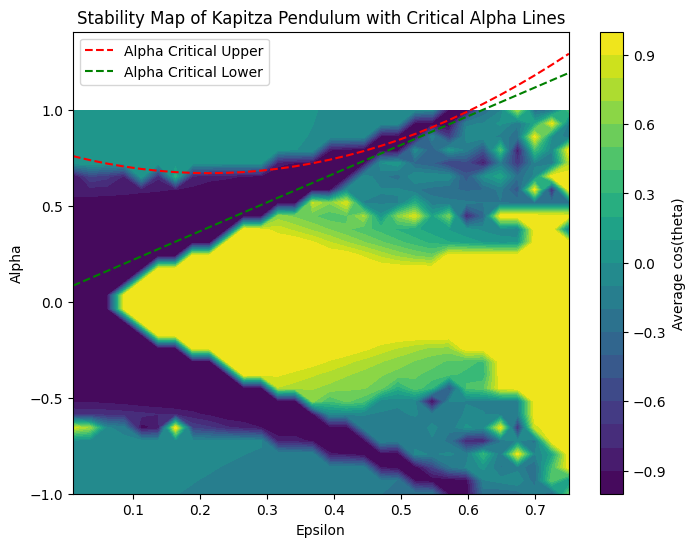

In [ ]:
#upper boundary of stabiliy valley
def alpha_critical_upper(epsilon, zeta, coef=2.16):
  """
  This function defines the upper boundary of the inverted state.
  PARAMETERS:
  epsilon : float
    dimensionless frequency : epsilon = omega_0/omega_d
  zeta : float
    dimensionless damping coefficient
  coef : float
    tuning parameter to help with fit
  RETURNS:
  alpha : float
    relative displacement of the pivot to the pendulum arm : alpha = y_0/l
  """
  alpha = coef*epsilon**2 - 0.92*epsilon + 0.77
  return alpha

#lower boundary of stability valley
def alpha_critical_lower(epsilon, zeta, coef=1.5):
  """
  This function defines the lower boundary of the inverted state.
  PARAMETERS:
  epsilon : float
    dimensionless frequency : epsilon = omega_0/omega_d
  zeta : float
    dimensionless damping coefficient
  coef : float
    tuning parameter to help with fit
  RETURNS:
  alpha : float
    relative displacement of the pivot to the pendulum arm : alpha = y_0/l
  """
  alpha = coef*epsilon + 0.07
  return alpha

#plotting the contour along with the fabricated stability boundary functions

plt.figure(figsize=(8,6)) # Increased figure size for better visualization
plt.contourf(epsilon_list, alpha_list, cos_theta_mesh.T, levels=20) # Added levels for smoother contours, and transposed cos_theta_mesh

# Calculate alpha critical upper and lower values
alpha_upper_values = alpha_critical_upper(epsilon_list, zeta)
alpha_lower_values = alpha_critical_lower(epsilon_list, zeta)

# Plot the critical alpha lines
plt.plot(epsilon_list, alpha_upper_values, color='red', linestyle='--', label='Alpha Critical Upper')
plt.plot(epsilon_list, alpha_lower_values, color='green', linestyle='--', label='Alpha Critical Lower')

plt.colorbar(label='Average cos(theta)')
plt.xlabel('Epsilon')
plt.ylabel('Alpha')
plt.title('Stability Map of Kapitza Pendulum with Critical Alpha Lines')
plt.legend()
plt.show()

## Comments:
### The two rudimentary boundary functions I fabricated are far from a perfect match but described the general idea. The stability valley is trapped between a function of concave up as an upper bound, and a linear function (or possibly a function of smaller concave up) as a lower bound. A higher resolution and perhaps better methodoloy would be necessary to find a more accurate boundary function.

# Summary:
### To numerically solve for the stability valley of the Kapitza pendulum, I employed several questionable tactics. From class, I stole the method for determining stability, taking an average of the cosine of theta across a number of decay periods. For the main plot, I chose to average along 50 decay periods to save time, assuming that that would still be long enough to tell the 'long-term' behavior of the pendulum. Once I created the first low-res contour plot from 0 to 1, I could see the general area of the stability valley. I then chose numerical parameters to create a higher resolution graph around the stability valley which occured from alpha ranging from -1 to 1, and from epsilon ranging from 0 to about 0.8. I then chose to only represent the top portion of the stability valley since the bottom is a mirror image of the top. By eyeballing it, I decided to go with a function of concave up for the upper bound, and a linear function for the lower bound. This led to me to roughly trapping the stability valley in between a line and parabola, but the functions are far from perfect. To get a better boundary condition, I believe a higher resolution contour plot would be vital.